In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

mpl.rc('font',**{'family':'serif','serif':['serif']})
mpl.rc('text', usetex=True)
import fitsio as fio

import copy

import xpipe.tools.catalogs as catalogs
import xpipe.paths as paths
import xpipe.xhandle.parbins as parbins
import xpipe.xhandle.xwrap as xwrap
import xpipe.tools.selector as selector
import xpipe.xhandle.shearops as shearops
import xpipe.xhandle.pzboost as pzboost
import xpipe.tools.y3_sompz as sompz
import xpipe.tools.mass as mass
import xpipe.tools.visual as visual


from importlib import reload
import pickle


import astropy.cosmology as cosmology
# this is just the default cosmology
cosmo = cosmology.FlatLambdaCDM(Om0=0.3, H0=70)

# we make sure the correct config file is loaded here, it will let us automatically now what type of files 
# were / will be produced, and where they will be placed
paths.update_params("/home/moon/vargatn/DES/PROJECTS/xpipe/settings/params_y3lwb_meta.yml")

updating params from: /home/moon/vargatn/DES/PROJECTS/xpipe/settings/params_y3lwb_meta.yml

***********************

running in full mode

***********************



# Creating lens fits table

xpipe takes a fits table as an input, with the columns specified in the config file

In [10]:
# first we load the CMASS data
tmp = np.loadtxt("DESY3_CMASS.dat")[:, (0, 1, 6, 7)]
cmass = pd.DataFrame(data=tmp, columns=("RA", "DEC", "WSYS", "Z"))
cmass["ID"] = np.arange(len(cmass), dtype=int) + 1e6
oname = "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/lenscat/LWB_DESY3_CMASS.fits"
# fio.write(oname, cmass.to_records(), clobber=True)

In [11]:
# # then the LOWZ data
tmp = np.loadtxt("DESY3_LOWZ.dat")[:, (0, 1, 6, 7)]
lowz = pd.DataFrame(data=tmp, columns=("RA", "DEC", "WSYS", "Z"))
lowz["ID"] = np.arange(len(lowz), dtype=int)
oname = "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/lenscat/LWB_DESY3_LOWZ.fits"
# fio.write(oname, lowz.to_records(), clobber=True)

In [12]:
# # and concatenate them, this is going to be useful to automating the lensing measurement
# # file names and paths will be taken care of automatically
allgal = pd.concat((lowz, cmass), ignore_index=True)
oname = "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/lenscat/LWB_DESY3_ALL.fits"
fio.write(oname, allgal.to_records(), clobber=True)

In [13]:
# now extract the lens weights, these are not used yet we can pass them on the post-processing stage
weights = pd.DataFrame()
weights["ww"] = allgal["WSYS"]
weights["ID"] = allgal["ID"]

# Running xpipe

* `python mkbins.py --norands --params=params_y3lwb_meta.yml`  this prepares the Jackknife regions and writes the lenses to the proper input format from the fits, table

* `python xshear_metacal.py --norands --params=params_y3lwb_meta.yml --runall` this runs the shear measurement 5 times for metacal, each JK region is processed separately, so for 1 profile up to ~500 different cores can be used simultaneously (assuming ~100 JK patches)

# Postprocessing the lensing signal

The Y3 xpipe setup measures shear, so we need to also access the DES Y3 photo-z cats

In [14]:
main_file_path = "/e/ocean1/users/vargatn/DESY3/Y3_mastercat_03_31_20.h5"
src = sompz.sompz_reader(main_file_path)
src.build_lookup()

In [15]:
# the output of xshear_metacal.py is in the following files.
# flist is the lenses
# rlist is the random points
flist, flist_jk, rlist, rlist_jk = parbins.get_file_lists(paths.params, paths.dirpaths)

In [29]:
ms_opt=[np.array([-0.02,-0.024,-0.037]),np.array([-0.024,-0.037]),np.array([-0.024,-0.037]),np.array([-0.037,])]
ms=[np.array([-0.024,-0.037]),np.array([-0.024,-0.037]),np.array([-0.024,-0.037]),np.array([-0.024,-0.037])]
  ## give it this 
optsbins=[(1,2,3),(2,3),(2,3),(3,)]

ACPs = []
ACP_ms = []
ACP_optms = []
for i, fname in enumerate(flist):
#     print(ms[i],optsbins[i])
    mfac_opt=1/(1+ms_opt[i])
    mfac=1/(1+ms[i])
    print(mfac, mfac_opt)
    
    ACP = shearops.AutoCalibrateProfile([fname,], flist_jk[i], src, xlims=(0.01, 30), sbins=(2, 3))
    ACP.get_profiles(ismeta=True, id_key="ID", z_key="Z", weights=weights) #
    ACPs.append(ACP)
    
    ACP = shearops.AutoCalibrateProfile([fname,], flist_jk[i], src, xlims=(0.01, 30), sbins=(2, 3))
    ACP.get_profiles(ismeta=True, id_key="ID", z_key="Z", weights=weights, mfactor_sbins=mfac) #
    ACP_ms.append(ACP)
    
    ACP = shearops.AutoCalibrateProfile([fname,], flist_jk[i], src, xlims=(0.01, 30), sbins=optsbins[i])
    ACP.get_profiles(ismeta=True, id_key="ID", z_key="Z", weights=weights, mfactor_sbins=mfac_opt) #
    ACP_optms.append(ACP)

[1.02459016 1.0384216 ] [1.02040816 1.02459016 1.0384216 ]
loading source bin 2
loading source bin 3
/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_in/lwb-y3-lowz+cmass_v02/lwb-y3-lowz+cmass_v02_y1clust_qbin-0.fits
loading source bin 2
loading source bin 3
/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_in/lwb-y3-lowz+cmass_v02/lwb-y3-lowz+cmass_v02_y1clust_qbin-0.fits
loading source bin 1
loading source bin 2
loading source bin 3
/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_in/lwb-y3-lowz+cmass_v02/lwb-y3-lowz+cmass_v02_y1clust_qbin-0.fits
[1.02459016 1.0384216 ] [1.02459016 1.0384216 ]
loading source bin 2
loading source bin 3
/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_in/lwb-y3-lowz+cmass_v02/lwb-y3-lowz+cmass_v02_y1clust_qbin-1.fits
loading source bin 2
loading source bin 3
/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_in/lwb-y3-lowz+cmass_v02/lwb-y3-lowz+cmass_v02_y1clust_qbin-1.fits
loading source bin 2
loading source bin 3


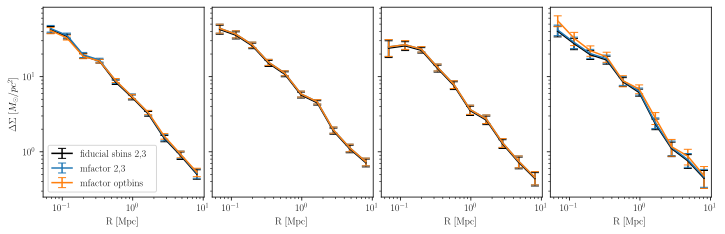

In [39]:
fig, axarr = plt.subplots(ncols=4, figsize=(12, 3.5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05)

for i in np.arange(4):

    
    prof = ACPs[i]
    axarr[i].errorbar(prof.rr, prof.dst, yerr=prof.dst_err, capsize=4, color="black", ls="-",
                      label="fiducial sbins 2,3")
    
    prof = ACP_ms[i]
    axarr[i].errorbar(prof.rr, prof.dst, yerr=prof.dst_err, capsize=4, color="C0", ls="-",
                      label="mfactor 2,3")
    
    prof = ACP_optms[i]
    axarr[i].errorbar(prof.rr, prof.dst, yerr=prof.dst_err, capsize=4, color="C1", ls="-",
                      label="mfactor optbins")
    
    axarr[i].set_xlabel("R [Mpc]")
    axarr[i].set_xscale("log")
    axarr[i].set_yscale("log")
    
axarr[0].legend()
    
    
axarr[0].set_ylabel("$\Delta\Sigma$ [$M_\odot  / pc^2$]")

fig.savefig("LWB_Deltasigma_sanity_check.png", bbox_inches="tight")

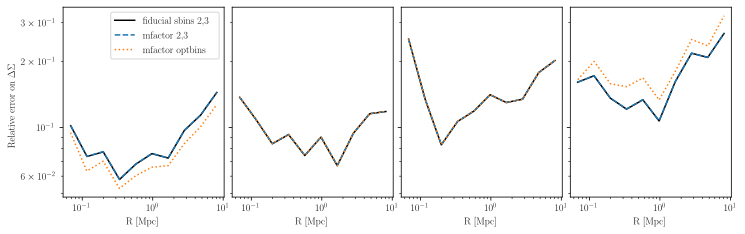

In [40]:
fig, axarr = plt.subplots(ncols=4, figsize=(12, 3.5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05)

for i in np.arange(4):

#     arr = np.zeros
    prof = ACPs[i]
    axarr[i].plot(prof.rr, prof.dst_err / prof.dst, color="black", ls="-",
                      label="fiducial sbins 2,3")
    
    prof = ACP_ms[i]
    axarr[i].plot(prof.rr, prof.dst_err / prof.dst, color="C0", ls="--",
                      label="mfactor 2,3")
    
    prof = ACP_optms[i]
    axarr[i].plot(prof.rr, prof.dst_err / prof.dst, color="C1", ls=":",
                      label="mfactor optbins")
    
    axarr[i].set_xlabel("R [Mpc]")
    axarr[i].set_xscale("log")
    axarr[i].set_yscale("log")
    

axarr[0].legend()
    
axarr[0].set_ylabel("Relative error on $\Delta\Sigma$ ")
fig.savefig("LWB_Deltasigma_sanity_check_relative_errors.png", bbox_inches="tight")


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


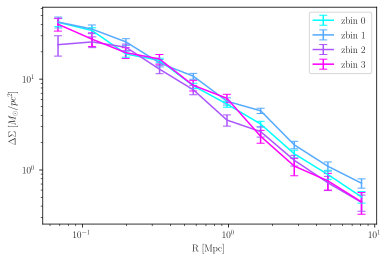

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

colors = plt.cm.cool(np.linspace(0, 1, 4))
for i in np.arange(4):
    prof = ACPs[i]
    ax.errorbar(prof.rr, prof.dst, yerr=prof.dst_err, capsize=4, color=colors[i], label="zbin "+str(i))

ax.legend()
ax.set_xlabel("R [Mpc]")
ax.set_ylabel("$\Delta\Sigma$ [$M_\odot  / pc^2$]")
# ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")

## Compare bin and m-factor selection

# Calculating boost factors from P(z) decomposition

xpipe automatically saves a fractin of source-lens pairs, and these are used to estimate the boost factors

In [ ]:
# !!! Uncomment this block and run once !!!

# # For each redshift bin
# for i in np.arange(4):
#     # First we need to match the source id with the BPZ photot-z
#     smb = pzboost.SOMBoost(src, [flist_jk[i],], sbins=)
#     smb.get_pair_datas(pair_outpath="lwb-y3-lowz+cmass_v02_y1clust_qbin-"+str(i)+"_pairs.h5") 
#     # this could take a few minutes or so
#     # It saves the matched version of the pairs to the specified file name    

In [44]:
reload(pzboost)

<module 'xpipe.xhandle.pzboost' from '/home/moon/vargatn/DES/PROJECTS/xpipe/xpipe/xhandle/pzboost.py'>

In [ ]:
# !!! Uncomment this block and run once !!!
optsbins=[(1,2,3),(2,3),(2,3),(3,)]
# # For each redshift bin
for i in np.arange(4):
    # First we need to match the source id with the BPZ photot-z
    smb = pzboost.SOMBoost(src, [flist_jk[i],], sbins=optsbins[i])
    smb.get_pair_datas(pair_outpath="lwb-y3-lowz+cmass_v02_y1clust_optsbins_qbin-"+str(i)+"_pairs.p") 
    #     # this could take a few minutes or so
    #     # It saves the matched version of the pairs to the specified file name    
    
# Then run this
optsbins=[(1, 2, 3),(2, 3),(2, 3),(3,)]
smbs = []
ACPs_boosted = []
for i in np.arange(4):
    # Load the pairs files pre-processed above
    smb = pzboost.SOMBoost(src, [flist_jk[i],], sbins=optsbins[i],
                           pairs_to_load="lwb-y3-lowz+cmass_v02_y1clust_optsbins_qbin-"+str(i)+"_pairs.p")
    smb.prep_boost(bins_to_use=np.arange(10)) # these are the indices of the radial bins to be used
    smb.get_boost(npdf=9) # use the inner 9 radial bins (and the last as the reference PDF)
    smbs.append(smb)
    ACP = copy.copy(ACP_optms[i])
    ACP.add_boost(smb)
    ACPs_boosted.append(ACP)

In [45]:
optsbins=[(1,2,3),(2,3),(2,3),(3,)]
for i in np.arange(4):
    # First we need to match the source id with the BPZ photot-z
    smb = pzboost.SOMBoost(src, [flist_jk[i],], sbins=optsbins[i])
    smb.get_pair_datas(pair_outpath="lwb-y3-lowz+cmass_v02_y1clust_optsbins_qbin-"+str(i)+"_pairs.p") 

0 1
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 1 10
0 1 11
0 1 12
0 1 13
0 1 14
0 1 15
0 1 16
0 1 17
0 1 18
0 1 19
0 1 20
0 1 21
0 1 22
0 1 23
0 1 24
0 1 25
0 1 26
0 1 27
0 1 28
0 1 29
0 1 30
0 1 31
0 1 32
0 1 33
0 1 34
0 1 35
0 1 36
0 1 37
0 1 38
0 1 39
0 1 40
0 1 41
0 1 42
0 1 43
0 1 44
0 1 45
0 1 46
0 1 47
0 1 48
0 1 49
0 1 50
0 1 51
0 1 52
0 1 53
0 1 54
0 1 55
0 1 56
0 1 57
0 1 58
0 1 59
0 1 60
0 1 61
0 1 62
0 1 63
0 1 64
0 1 65
0 1 66
0 1 67
0 1 68
0 1 69
0 1 70
0 1 71
0 1 72
0 1 73
0 1 74
0 1 75
0 1 76
0 1 77
0 1 78
0 1 79
0 1 80
0 1 81
0 1 82
0 1 83
0 1 84
0 1 85
0 1 86
0 1 87
0 1 88
0 1 89
0 1 90
0 1 91
0 1 92
0 1 93
0 1 94
0 1 95
0 1 96
0 1 97
0 1 98
0 1 99
merged catalogs
0 2
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 2 5
0 2 6
0 2 7
0 2 8
0 2 9
0 2 10
0 2 11
0 2 12
0 2 13
0 2 14
0 2 15
0 2 16
0 2 17
0 2 18
0 2 19
0 2 20
0 2 21
0 2 22
0 2 23
0 2 24
0 2 25
0 2 26
0 2 27
0 2 28
0 2 29
0 2 30
0 2 31
0 2 32
0 2 33
0 2 34
0 2 35
0 2 36
0 2 37
0 2 38
0 2 39
0 2 40
0 2 41
0 

In [53]:
tab = pickle.load(open("lwb-y3-lowz+cmass_v02_y1clust_optsbins_qbin-0_pairs.h5", "rb"))

In [60]:
len(tab[0])

3

In [62]:
reload(pzboost)

<module 'xpipe.xhandle.pzboost' from '/home/moon/vargatn/DES/PROJECTS/xpipe/xpipe/xhandle/pzboost.py'>

In [64]:
i = 0
optsbins=[(1, 2, 3),(2, 3),(2, 3),(3,)]
smb = pzboost.SOMBoost(src, [flist_jk[i],], sbins=optsbins[i],
                       pairs_to_load="lwb-y3-lowz+cmass_v02_y1clust_optsbins_qbin-"+str(i)+"_pairs.h5")
smb.prep_boost(bins_to_use=np.arange(10)) # these are the indices of the radial bins to be used
smb.get_boost(npdf=9) # use the inner 9 radial bins (and the last as the reference PDF)

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
0 0
0 1


/home/moon/vargatn/anaconda3/envs/main3/lib/python3.8/site-packages/scipy/optimize/_lsq/common.py:453: RuntimeWarning: underflow encountered in nextafter
  x_new[lower_mask] = np.nextafter(lb[lower_mask], ub[lower_mask])
/home/moon/vargatn/DES/PROJECTS/xpipe/xpipe/xhandle/pzboost.py:975: RuntimeWarning: underflow encountered in multiply
  self.mixarr[i, :] = amps[i] * garr + (1. - amps[i]) * self.refpdf
/home/moon/vargatn/anaconda3/envs/main3/lib/python3.8/site-packages/scipy/optimize/_lsq/trf.py:263: RuntimeWarning: underflow encountered in multiply
  g_norm = norm(g * v, ord=np.inf)


0 2


In [63]:
smb

In [65]:
optsbins=[(1, 2, 3),(2, 3),(2, 3),(3,)]
smbs = []
ACPs_boosted = []
for i in np.arange(4):
    # Load the pairs files pre-processed above
    smb = pzboost.SOMBoost(src, [flist_jk[i],], sbins=optsbins[i],
                           pairs_to_load="lwb-y3-lowz+cmass_v02_y1clust_optsbins_qbin-"+str(i)+"_pairs.h5")
    smb.prep_boost(bins_to_use=np.arange(10)) # these are the indices of the radial bins to be used
    smb.get_boost(npdf=9) # use the inner 9 radial bins (and the last as the reference PDF)
    smbs.append(smb)
    ACP = copy.copy(ACP_optms[i])
    ACP.add_boost(smb)
    ACPs_boosted.append(ACP)

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
0 0
0 1


/home/moon/vargatn/anaconda3/envs/main3/lib/python3.8/site-packages/scipy/optimize/_lsq/common.py:453: RuntimeWarning: underflow encountered in nextafter
  x_new[lower_mask] = np.nextafter(lb[lower_mask], ub[lower_mask])
/home/moon/vargatn/DES/PROJECTS/xpipe/xpipe/xhandle/pzboost.py:975: RuntimeWarning: underflow encountered in multiply
  self.mixarr[i, :] = amps[i] * garr + (1. - amps[i]) * self.refpdf
/home/moon/vargatn/anaconda3/envs/main3/lib/python3.8/site-packages/scipy/optimize/_lsq/trf.py:263: RuntimeWarning: underflow encountered in multiply
  g_norm = norm(g * v, ord=np.inf)


0 2


/home/moon/vargatn/DES/PROJECTS/xpipe/xpipe/xhandle/shearops.py:977: RuntimeWarning: underflow encountered in multiply
  tmps.append(_amp * self.scinvs[i])


(9,)
1
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
0 0
0 1
(9,)
1
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
0 0
0 1
(9,)
1
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
0 0
(9,)
1


Text(0, 0.5, '$\\Delta\\Sigma$ [$M_\\odot  / pc^2$]')

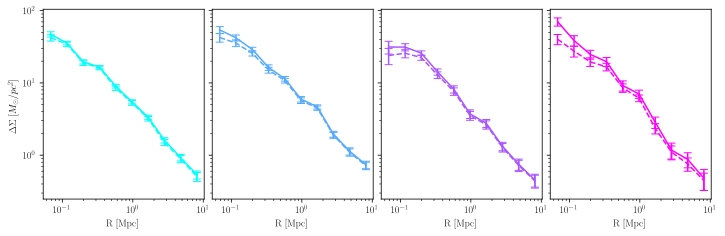

In [66]:
fig, axarr = plt.subplots(ncols=4, figsize=(12, 3.5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05)

for i in np.arange(4):
    prof = ACPs_boosted[i]
    axarr[i].errorbar(prof.rr, prof.dst, yerr=prof.dst_err, capsize=4, color=colors[i], label="zbin "+str(i))
    
    prof = ACPs[i]
    axarr[i].errorbar(prof.rr, prof.dst, yerr=prof.dst_err, capsize=4, color=colors[i], ls="--")

    
    axarr[i].set_xlabel("R [Mpc]")
    axarr[i].set_xscale("log")
    axarr[i].set_yscale("log")
    
axarr[0].set_ylabel("$\Delta\Sigma$ [$M_\odot  / pc^2$]")


In [2]:
import fitsio as fio

In [8]:
tab = fio.read("/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/lenscat/LWB_DESY3_ALL_rand.fits")

In [10]:
tab.shape

(5612713,)

In [5]:
tab = fio.read("/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/lenscat/LWB_DESY3_ALL.fits")

In [7]:
tab.shape

(98782,)